In [1]:
# Import packages. Download gensim and wordcloud if you haven't.
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
from ipywidgets import widgets, interactive
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.parsing.preprocessing import preprocess_string
import imblearn

In [4]:
# Import datasets
df_train = pd.read_csv('../assets/df_train.csv',index_col=0)
df_test = pd.read_csv('../assets/df_test.csv',index_col=0)

In [5]:
# Preprocess Strings (Lemmatize, Remove Stopwords, etc.)
df_train['tweet_text'] = df_train['tweet_text'].apply(lambda x:" ".join(preprocess_string(x)))
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x:" ".join(preprocess_string(x)))

In [6]:
# Train TfIdf vectorizer and remove
vec_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=1,max_features=1000)
X_train_tfidf = vec_tfidf.fit_transform(df_train.tweet_text)
X_test_tfidf = vec_tfidf.transform(df_test.tweet_text)

In [7]:
# map labels to ordinal values
unique_labels = df_train['class_label'].unique()
dict_label = dict(zip(unique_labels,np.arange(len(unique_labels))))
y_train = df_train['class_label'].map(dict_label)
y_test = df_test['class_label'].map(dict_label)

In [16]:
# Create and fit the logistic regressor
lr = LogisticRegression(random_state = 42,max_iter=10000)
lr.fit(X_train_tfidf,y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [17]:
# Test the regressor's performance on the test set.
y_test_predict = lr.predict(X_test_tfidf)
print('Accuracy: ',accuracy_score(y_test,y_test_predict))
print('Precision: ',precision_score(y_test,y_test_predict,average='macro'))
print('Recall: ',recall_score(y_test,y_test_predict,average='macro'))
print('F-1 Score: ',f1_score(y_test,y_test_predict,average='macro'))

Accuracy:  0.7342675832892649
Precision:  0.7293932397980467
Recall:  0.6578913562398816
F-1 Score:  0.6824750204675245


In [10]:
# What are the most important words in identifying each category?
# We can see the most important words are highly
top_words = 10
coef_sorted = np.zeros_like(lr.coef_)
for category_idx in range(lr.coef_.shape[0]):
    index_sort = np.argsort(lr.coef_[category_idx,:])
    top_names = [vec_tfidf.get_feature_names()[index_sort[-i]] for i in range(1,top_words+1)]
    print(unique_labels[category_idx],':',top_names)

other_relevant_information : ['irma', 'flood', 'irma victim', 'climat', 'reason', 'aftershock', 'trump', 'hurricaneharvei', 'irma relief', 'dorian']
displaced_people_and_evacuations : ['evacu', 'evacue', 'displac', 'shelter', 'flee', 'homeless', 'mandatori', 'resid', 'order', 'million peopl']
rescue_volunteering_or_donation_effort : ['donat', 'rescu', 'volunt', 'relief', 'rescuer', 'help', 'aid', 'fundrais', 'rais', 'deliv']
caution_and_advice : ['warn', 'emerg', 'tip', 'tornado', 'danger', 'prepar', 'flood', 'edt', 'hurricaneflor', 'declar']
sympathy_and_support : ['prai', 'prayer', 'thought', 'heart', 'support', 'allah', 'help', 'condol', 'safe', 'hope']
infrastructure_and_utility_damage : ['damag', 'destroi', 'destruct', 'collaps', 'power', 'build', 'home', 'hous', 'road', 'tree']
not_humanitarian : ['trump', 'realdonaldtrump', 'job', 'instead', 'blame', 'fuck', 'kill', 'vote', 'tax', 'nebraska']
requests_or_urgent_needs : ['help', 'need', 'urgent', 'donat', 'food', 'request', 'medi

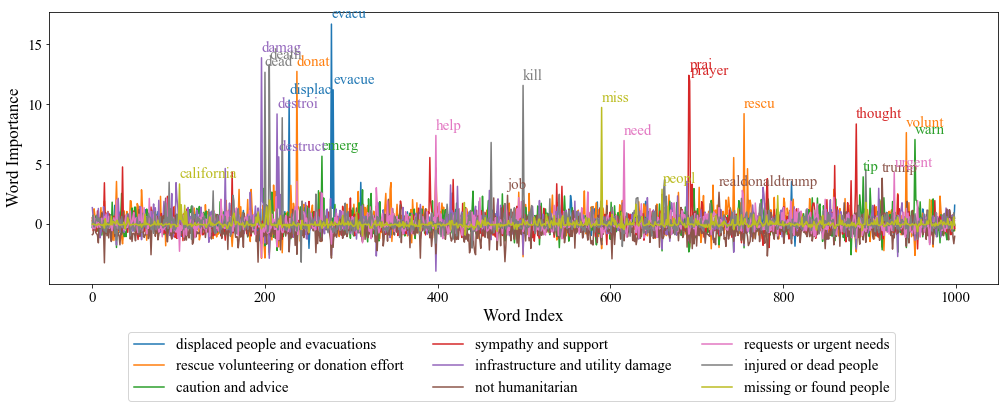

In [11]:
# Personally think this plot is rather good, but some interactivity (selection on figure) might actually be better
fig,ax = plt.subplots(figsize=(17,5))
for category_idx in range(1,lr.coef_.shape[0]):
    ax.plot(np.arange(lr.coef_.shape[1]),lr.coef_[category_idx,:],label=unique_labels[category_idx].replace('_',' '))
    ax.tick_params(labelsize=15)
    ax.set_xlabel("Word Index",fontsize=17)
    ax.set_ylabel("Word Importance",fontsize=17)
    index_sort = np.argsort(lr.coef_[category_idx,:])
    for i in range(-3,0):
        ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr.coef_[category_idx,index_sort[i]]+0.5),fontsize=15,color=plt.gca().lines[-1].get_color())
    plt.legend(bbox_to_anchor=(0.9, -0.15),ncol=3,fontsize=15)

In [12]:
# Interactivity plots for each category. 
# I have uploaded a demo video of this part to google drive: https://drive.google.com/file/d/1IHhPBQ5udS1PWJG4IMEJcark8dO00gE4/view?usp=sharing.
# This should come in handy for writing reports.
output = widgets.Output()
unique_labels_transformed = [i.replace('_',' ') for i in list(unique_labels)]

def clicked(b):
    
    output.clear_output(wait=True)
    with output:
        category = filterdrop.value
        if category=='Select One...':
            pass
        else:
            fig,ax = plt.subplots(figsize=(17,5))
            category_idx = unique_labels_transformed.index(category)
            ax.plot(np.arange(lr.coef_.shape[1]),lr.coef_[category_idx,:])
            ax.tick_params(labelsize=15)
            ax.set_xlabel("Word Index",fontsize=17)
            ax.set_ylabel("Word Importance",fontsize=17)
            index_sort = np.argsort(lr.coef_[category_idx,:])
            for i in range(-20,0):
                ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr.coef_[category_idx,index_sort[i]]),fontsize=15,color=plt.gca().lines[-1].get_color())
            plt.show()


filterdrop = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Category: ",
    disabled = False
)
filterdrop.observe(clicked)
display(filterdrop,output)


Dropdown(description='Category: ', options=('Select One...', 'other relevant information', 'displaced people a…

Output()

In [13]:
# Or alternatively, a wordcloud could be more intuitive.

output2 = widgets.Output()
unique_labels_transformed = [i.replace('_',' ') for i in list(unique_labels)]

def clicked_2(b):
    output2.clear_output(wait=True)
    with output2:
        category = filterdrop_2.value
        if category=='Select One...':
            pass
        else:
            category_idx = unique_labels_transformed.index(category)
            index_sort = np.argsort(lr.coef_[category_idx,:])
            weights = [(lr.coef_[category_idx,index_sort[-i]],vec_tfidf.get_feature_names()[index_sort[-i]]) for i in range(1,51)]
            weights = dict(zip([vec_tfidf.get_feature_names()[index_sort[-i]] for i in range(1,51)],[lr.coef_[category_idx,index_sort[-i]] for i in range(1,51)]))
            wc = WordCloud(background_color='white', stopwords= None, max_words=50)
            wc.generate_from_frequencies(weights)
            plt.figure(figsize=(10,5),facecolor = 'white', edgecolor='blue')
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.tight_layout(pad=0)
            plt.show()


filterdrop_2 = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Category: ",
    disabled = False
)
filterdrop_2.observe(clicked_2)
display(filterdrop_2,output2)
# unique_str  = ' '.join(feature_names[index_sort[-i]] for i in range(1,21))
# generate_wordcloud(unique_str)

Dropdown(description='Category: ', options=('Select One...', 'other relevant information', 'displaced people a…

Output()

In [14]:
# Failure Analysis. 
failure_idx = [i for i in range(len(y_test)) if y_test.iloc[i]-y_test_predict[i]]
len(failure_idx)

# Feel free to change the idx index to explore. In the case of idx=2, there are two keywords ('finance' and 'evacuate'),
# which caused the classifier to predict wrong (This happens to other indices too, such as idx=5).
idx = 2
print(df_test.tweet_text.iloc[failure_idx[idx]])
print('True Label: ',unique_labels[y_test.iloc[failure_idx[idx]]])
print('Predicted Label: ',unique_labels[y_test_predict[failure_idx[idx]]])

happyfollowback financi relief wildfir evacue teamfollowback
True Label:  rescue_volunteering_or_donation_effort
Predicted Label:  displaced_people_and_evacuations


In [15]:
# I'm also curious as to whether the tweets can help identify which disaster it is.
unique_labels_disaster = df_train['disaster'].unique()
dict_label_disaster = dict(zip(unique_labels_disaster,np.arange(len(unique_labels_disaster))))
y_train_disaster = df_train['disaster'].map(dict_label_disaster)
y_test_disaster = df_test['disaster'].map(dict_label_disaster)
lr_disaster = LogisticRegression(random_state = 42,max_iter=10000)
lr_disaster.fit(X_train_tfidf,y_train_disaster)
y_test_predict_disaster = lr_disaster.predict(X_test_tfidf)
print('Accuracy: ',accuracy_score(y_test_disaster,y_test_predict_disaster))
print('Precision: ',precision_score(y_test_disaster,y_test_predict_disaster,average='macro'))
print('Recall: ',recall_score(y_test_disaster,y_test_predict_disaster,average='macro'))
print('F-1 Score: ',f1_score(y_test_disaster,y_test_predict_disaster,average='macro'))

Accuracy:  0.9629825489159175
Precision:  0.978722131079018
Recall:  0.9398993420267177
F-1 Score:  0.9584271200404004


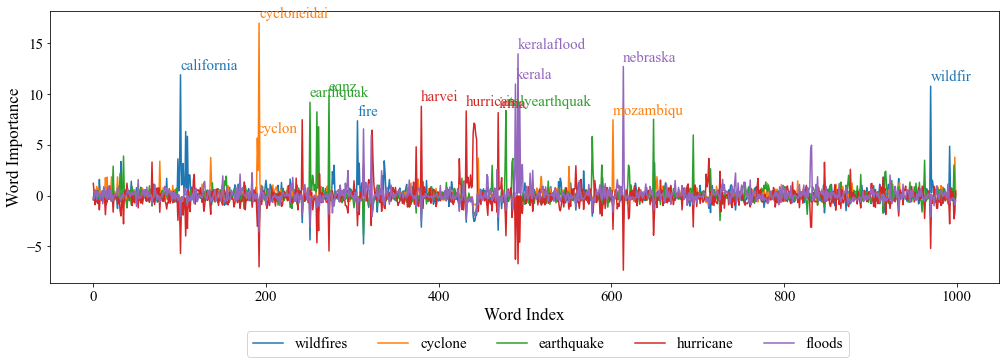

In [16]:
# Plot out word importance graph. Not surprisingly, many tweets already explicitly include disaster information.
fig,ax = plt.subplots(figsize=(17,5))
for category_idx in range(lr_disaster.coef_.shape[0]):
    ax.plot(np.arange(lr_disaster.coef_.shape[1]),lr_disaster.coef_[category_idx,:],label=unique_labels_disaster[category_idx])
    ax.tick_params(labelsize=15)
    ax.set_xlabel("Word Index",fontsize=17)
    ax.set_ylabel("Word Importance",fontsize=17)
    index_sort = np.argsort(lr_disaster.coef_[category_idx,:])
    for i in range(-3,0):
        ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr_disaster.coef_[category_idx,index_sort[i]]+0.5),fontsize=15,color=plt.gca().lines[-1].get_color())
    plt.legend(bbox_to_anchor=(0.85, -0.15),ncol=6,fontsize=15)

In the following, we show that despite the outstanding performance of tweets, an imbalanced label distribution has led to a biased model (not ethical though, so I guess it's okay). 

In [18]:
df_test_temp = df_test.reset_index()
acc_list = []
for label in df_test_temp['class_label'].unique():
    index_list = list(df_test_temp.loc[df_test_temp.class_label==label].index)
    acc_list.append(accuracy_score(np.array(y_test)[index_list],np.array(y_test_predict)[index_list]))
print(acc_list)

[0.8696470588235294, 0.7549132947976879, 0.7912087912087912, 0.599502487562189, 0.8704156479217604, 0.40605095541401276, 0.587037037037037, 0.4312977099236641, 0.9188405797101449, 0.35]


Text(0, 0.5, 'Accuracy')

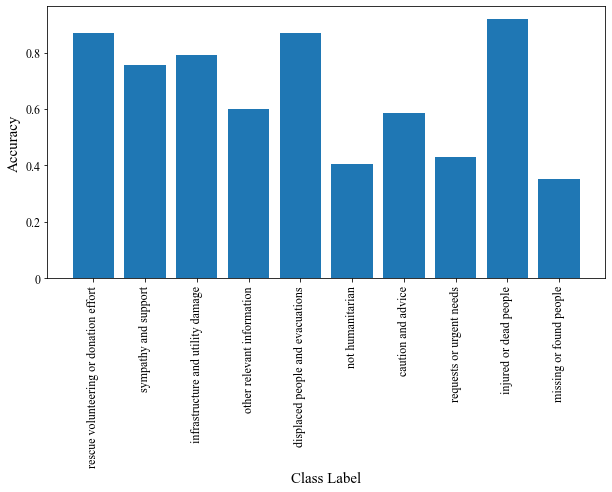

In [46]:
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(len(acc_list)),acc_list)
ax.set_xticks(np.arange(len(acc_list)))
ax.set_xticklabels([i.replace('_',' ') for i in list(df_test_temp['class_label'].unique())],rotation=90,fontsize=12)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8],fontsize=12)
ax.set_xlabel('Class Label',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)

<AxesSubplot:>

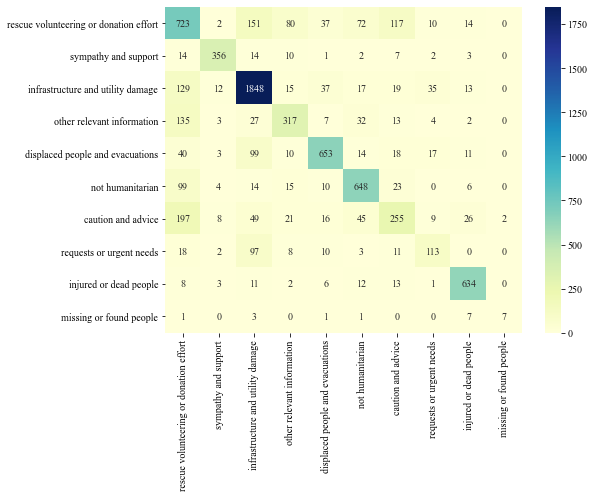

In [58]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,6))
con_mat = confusion_matrix(np.array(y_test), np.array(y_test_predict))
df = pd.DataFrame(con_mat,index =  [i.replace('_',' ') for i in list(df_test_temp['class_label'].unique())],columns=[i.replace('_',' ') for i in list(df_test_temp['class_label'].unique())])
sns.heatmap(df,ax=ax,cmap = "YlGnBu",annot=True,fmt='.0f')

What if we resample the dataset to let the minorities become more representative?

In [8]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_tfidf_oversampling,y_train_oversampling = ros.fit_resample(X_train_tfidf, y_train)
lr_resampled = LogisticRegression(random_state = 0,max_iter=10000)
lr_resampled.fit(X_train_tfidf_oversampling,y_train_oversampling)

LogisticRegression(max_iter=10000, random_state=0)

In [12]:
# Test the regressor's performance on the test set.
y_test_predict_oversampling = lr_resampled.predict(X_test_tfidf)
print('Accuracy: ',accuracy_score(y_test,y_test_predict_oversampling))
print('Precision: ',precision_score(y_test,y_test_predict_oversampling,average='macro'))
print('Recall: ',recall_score(y_test,y_test_predict_oversampling,average='macro'))
print('F-1 Score: ',f1_score(y_test,y_test_predict_oversampling,average='macro'))

Accuracy:  0.6977789529349551
Precision:  0.641490474702979
Recall:  0.7159939217122623
F-1 Score:  0.6647862588364758


<AxesSubplot:>

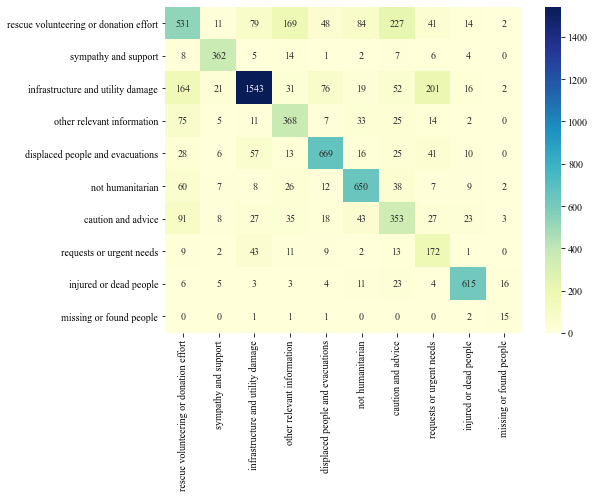

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,6))
con_mat = confusion_matrix(np.array(y_test), np.array(y_test_predict_oversampling))
df = pd.DataFrame(con_mat,index =  [i.replace('_',' ') for i in list(df_test['class_label'].unique())],columns=[i.replace('_',' ') for i in list(df_test_temp['class_label'].unique())])
sns.heatmap(df,ax=ax,cmap = "YlGnBu",annot=True,fmt='.0f')

Text(0, 0.5, 'Accuracy')

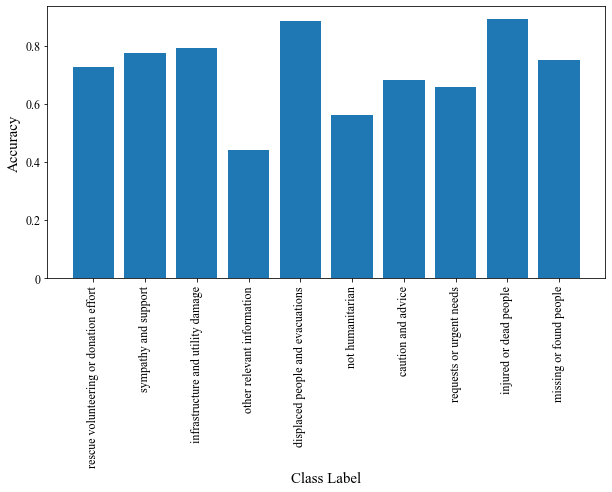

In [20]:
df_test_temp = df_test.reset_index()
acc_list = []
for label in df_test_temp['class_label'].unique():
    index_list = list(df_test_temp.loc[df_test_temp.class_label==label].index)
    acc_list.append(accuracy_score(np.array(y_test)[index_list],np.array(y_test_predict_oversampling)[index_list]))
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(len(acc_list)),acc_list)
ax.set_xticks(np.arange(len(acc_list)))
ax.set_xticklabels([i.replace('_',' ') for i in list(df_test_temp['class_label'].unique())],rotation=90,fontsize=12)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8],fontsize=12)
ax.set_xlabel('Class Label',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)

We can see that the overall accuracy has dropped, but the model now seems to be more "fair" across class labels.